In [1]:
import cv2
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import sys
import itertools
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
import time
from sklearn.linear_model import LogisticRegression

In [2]:
num_samples = 1000
# Function to load the images given the folder name
def load_path(path):
    imgs = []
    files = listdir('./MIO-TCD-Classification/train/{}/'.format(path))
    img_counter = 0
    for img in files:
        img = cv2.cvtColor(cv2.imread('./MIO-TCD-Classification/train/{}/{}'.format(path,img)), cv2.COLOR_BGR2GRAY)
        kernel = np.array([[1/9,1/9,1/9], [1/9,1/9,1/9], [1/9,1/9,1/9]])
        img = cv2.filter2D(img, -1, kernel)
        img = cv2.resize(img, (64,64))
        imgs.append(img)
        img_counter += 1
        if(img_counter==num_samples): break
    return imgs

In [3]:
articulated_truck = load_path('articulated_truck')
background = load_path('background')
bicycle = load_path('bicycle')
bus = load_path('bus')
car = load_path('car')
motorcycle = load_path('motorcycle')
non_motorized_vehicle = load_path('non-motorized_vehicle')
pedestrian = load_path('pedestrian')
pickup_truck = load_path('pickup_truck')
single_unit_truck = load_path('single_unit_truck')
work_van = load_path('work_van')

In [4]:
X = articulated_truck + background + bicycle + bus + car + motorcycle + non_motorized_vehicle + pedestrian + pickup_truck + single_unit_truck + work_van
y = ['articulated_truck']*num_samples + ['background']*num_samples + ['bicycle']*num_samples + ['bus']*num_samples + ['car']*num_samples + ['motorcycle']*num_samples + ['non_motorized_vehicle']*num_samples + ['pedestrian']*num_samples + ['pickup_truck']*num_samples + ['single_unit_truck']*num_samples + ['work_van']*num_samples

In [5]:
# Function to compute HoG features of a list of images
def compute_HoG(imgs, cell_size, block_size, nbins, h, w):
    img_features = []
    hog = cv2.HOGDescriptor(_winSize=((w // cell_size[1]) * cell_size[1],
                                  (h // cell_size[0]) * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)
    n_cells = (h // cell_size[0], w // cell_size[1])
    
    for img in imgs:

        hog_feats = hog.compute(img)\
                .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
                
        # computation for BlockNorm

        gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        
        img_features.append(gradients)
        
    return img_features

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=69)


c_size = (4,4)
b_size = (4,4)
bins = 8
height = 64
width = 64

HoG_feat = compute_HoG(X_train, c_size, b_size, bins, height, width)

In [7]:
# Part 4
then = time.clock()
clf = LinearSVC()
HoG_feat = np.array(HoG_feat)
clf.fit(HoG_feat.reshape(HoG_feat.shape[0],-1),y_train)
now = time.clock()
print(now - then)

65.97979658821322


In [8]:
then = time.clock()
HoG_feat_test = compute_HoG(X_test, c_size, b_size, bins, height, width)
HoG_feat_test = np.array(HoG_feat_test)
pred = clf.predict(HoG_feat_test.reshape(HoG_feat_test.shape[0],-1))
now = time.clock()
print(now - then)
print(classification_report(y_test,pred))

2.063422633352431
                       precision    recall  f1-score   support

    articulated_truck       0.59      0.61      0.60       158
           background       0.71      0.80      0.76       152
              bicycle       0.66      0.58      0.62       150
                  bus       0.56      0.63      0.59       130
                  car       0.67      0.77      0.72       152
           motorcycle       0.61      0.64      0.62       151
non_motorized_vehicle       0.62      0.57      0.59       143
           pedestrian       0.63      0.60      0.61       147
         pickup_truck       0.58      0.60      0.59       147
    single_unit_truck       0.56      0.45      0.50       168
             work_van       0.65      0.62      0.64       152

          avg / total       0.62      0.62      0.62      1650



Normalized confusion matrix


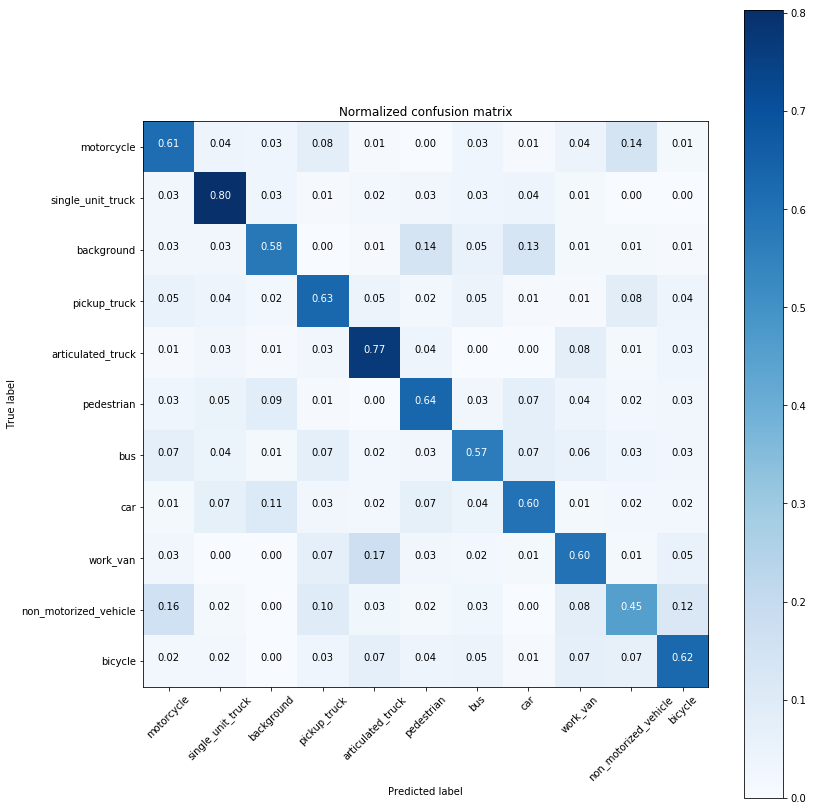

In [9]:
# Adapted from sklearn COnfusion Matrix tutorial
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (12,12))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes = list(set(y_test)),
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = list(set(y_test)), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [10]:
then = time.clock()
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
clf.fit(HoG_feat.reshape(HoG_feat.shape[0],-1),y_train)
now = time.clock()
print(now - then)

6.336144531862445


In [11]:
then = time.clock()
HoG_feat_test = compute_HoG(X_test, c_size, b_size, bins, height, width)
HoG_feat_test = np.array(HoG_feat_test)
pred = clf.predict(HoG_feat_test.reshape(HoG_feat_test.shape[0],-1))
now = time.clock()
print(now - then)
print(classification_report(y_test,pred))

1.9983622189722468
                       precision    recall  f1-score   support

    articulated_truck       0.60      0.59      0.59       158
           background       0.75      0.77      0.76       152
              bicycle       0.66      0.63      0.64       150
                  bus       0.51      0.60      0.55       130
                  car       0.65      0.72      0.69       152
           motorcycle       0.60      0.64      0.62       151
non_motorized_vehicle       0.62      0.57      0.60       143
           pedestrian       0.61      0.62      0.61       147
         pickup_truck       0.60      0.58      0.59       147
    single_unit_truck       0.60      0.49      0.54       168
             work_van       0.63      0.64      0.63       152

          avg / total       0.62      0.62      0.62      1650



Normalized confusion matrix


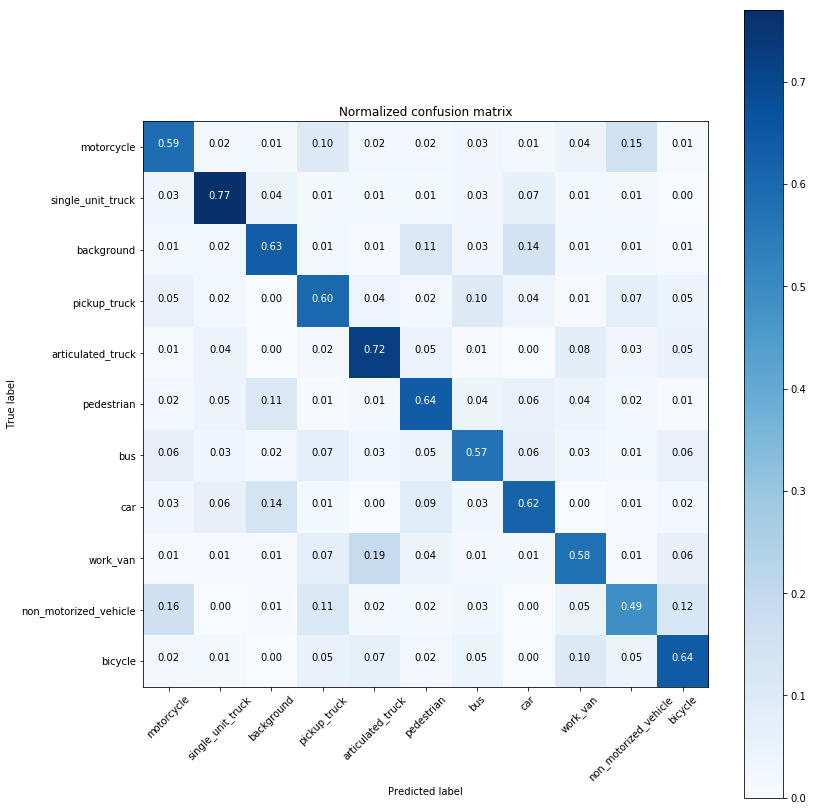

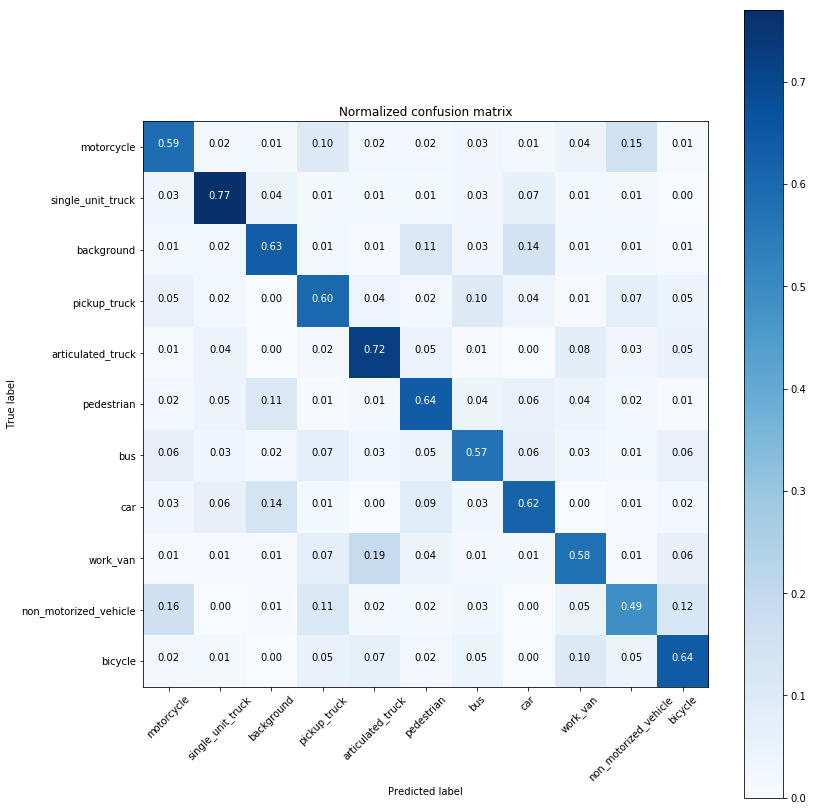

In [13]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes = list(set(y_test)), normalize=True,
                      title='Normalized confusion matrix')

plt.show()